# MS026 Epoching
06/27/2023

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import mne
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import os 
import joblib
import emd
import re
import scipy

import warnings
warnings.filterwarnings('ignore')

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [3]:
import sys
sys.path.append('/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/scripts/saez_python_pipeline/LFPAnalysis')

In [4]:
from LFPAnalysis import lfp_preprocess_utils, sync_utils, analysis_utils, nlx_utils

In [5]:
# Specify root directory for un-archived data and results 
base_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/'
anat_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/anat_recons/recon_labels/'
neural_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/data/'
behav_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/behavior_analysis/behavior_preprocessed/'

subj_id = 'MS026'
subj_format = ['nlx']
subj_site = ['MSSM']


### Import Preprocessed Data

In [6]:
mne_data_reref = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/wm_ref_ieeg.fif', preload=True)

photodiode_data = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/photodiode.fif', preload=True)

In [26]:
mne_data_reref

<Raw | wm_ref_ieeg.fif, 135 x 1815856 (3631.7 s), ~1.83 GB, data loaded>

In [7]:
photodiode_data

<Raw | photodiode.fif, 1 x 1815856 (3631.7 s), ~13.9 MB, data loaded>

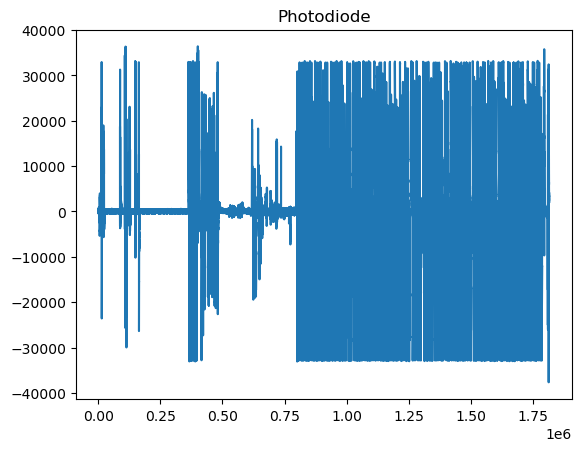

In [28]:
# Sanity check the photodiode
plt.plot(photodiode_data._data[0,])
plt.title("Photodiode")
plt.show()

### Load Anat Recon Info 


In [8]:
# Load the electrode localization data
anat_file = glob(f'{anat_dir}{subj_id}_labels.csv')[0]
elec_locs = pd.read_csv(anat_file)
# Sometimes there's extra columns with no entries: 
elec_locs = elec_locs[elec_locs.columns.drop(list(elec_locs.filter(regex='Unnamed')))]

elec_locs

,label,BN246label,x,y,z,mni_x,mni_y,mni_z,gm,NMM,Anat,AnatMacro,BN246,YBA_1,ManualExamination,Notes
0,LaCaS1,A32sg_L,-2.954574,41.329210,4.799997,-3.150189,27.626674,-11.313929,Gray,Left ACgG anterior cingulate gyrus,Area s24,L Mid Orbital Gyrus,L CG,Left cingulate gyrus C,NaN,NaN
1,LaCaS10,A9/46d_L,-14.150090,45.726392,48.399994,-14.612690,45.647438,30.886915,White,Left Cerebral White Matter,Unknown,L Superior Frontal Gyrus,L MFG,Unknown,WM,NaN
2,LaCaS11,A9l_L,-15.349610,46.126136,53.199994,-16.068791,47.523347,35.735259,Gray,Left SFG superior frontal gyrus,Unknown,L Superior Frontal Gyrus,L SFG,Left superior frontal gyrus 2 D,WM,NaN
3,LaCaS12,A9l_L,-16.149290,46.126136,57.999994,-17.096981,48.985539,40.715012,Gray,Left SFG superior frontal gyrus,Unknown,L Superior Frontal Gyrus,L SFG,Left superior frontal gyrus 2 D,OOB,NaN
4,LaCaS13,Unknown,-16.948969,46.126136,63.599993,-18.060868,50.562598,46.419275,Unknown,Unknown,Unknown,L Superior Frontal Gyrus,Unknown,Left superior frontal gyrus 2 D,OOB,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,RmOlF6,A11l_R,33.430855,50.123574,8.399997,36.273305,37.087206,-11.909190,Gray,Right LOrG lateral orbital gyrus,Unknown,R IFG (p Orbitalis),R OrG,Right pars orbitalis B,WM,NaN
164,RmOlF7,A12/47o_R,37.429254,49.723831,10.399996,40.477926,37.432671,-9.831393,Gray,Right Cerebral White Matter,Unknown,R IFG (p Orbitalis),R OrG,Right pars orbitalis B,NaN,NaN
165,RmOlF8,A12/47l_R,42.227333,49.723831,12.399996,45.600992,38.133258,-7.732312,Gray,Right OrIFG orbital part of the inferior front...,Unknown,R IFG (p Orbitalis),R OrG,Right anterior pars triangularis A,NaN,NaN
166,RmOlF9,A45r_R,46.625571,49.723831,14.799996,50.223671,38.960073,-5.163690,Gray,Right TrIFG triangular part of the inferior fr...,Unknown,R IFG (p Orbitalis),R IFG,Right anterior pars triangularis A,NaN,NaN


## Load behavior

In [9]:
behav_df = pd.read_csv(f'{behav_dir}{subj_id}_pt_task_data')
behav_df = behav_df[behav_df.columns.drop(list(behav_df.filter(regex='Unnamed')))]
behav_df

,Round,Trial Num,TrialType,TrialOnset,ChoiceOnset,DecisionOnset,FeedbackOnset,RT,SafeBet,LowBet,...,weighted_low,p_g,p_s,util_rpe,util_tcpe,util_dcpe,util_tregret,util_dregret,util_trelief,util_drelief
0,1,31.0,mix,64.988546,65.002196,72.045678,72.053316,7.043482,0.0,-1.50,...,-1.550829,0.083009,0.916991,0.000000,1.550829,1.550829,0.000000,0.000000,1.550829,1.550829
1,2,39.0,mix,78.824276,78.830170,82.056793,82.063629,3.226624,0.0,-0.50,...,-0.317991,0.506100,0.493900,0.000000,-0.330196,-0.330196,-0.330196,-0.330196,0.000000,0.000000
2,3,56.0,gain,89.270097,89.281084,92.684523,94.700933,3.403439,0.2,0.00,...,0.000000,0.558965,0.441035,-0.216662,-0.216662,-0.098148,-0.216662,-0.098148,0.000000,0.000000
3,4,95.0,gain,109.076507,109.084701,112.124336,114.140568,3.039634,0.6,0.00,...,0.000000,0.694203,0.305797,-0.888701,-0.888701,-0.478662,-0.888701,-0.478662,0.000000,0.000000
4,5,59.0,gain,119.506867,119.507606,123.534525,125.551429,4.026918,0.2,0.00,...,0.000000,0.641343,0.358657,0.000000,0.000000,0.290681,0.000000,0.000000,0.388829,0.290681
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,146,118.0,loss,2121.553007,2121.553719,2124.359392,2126.374574,2.805673,-0.3,-1.08,...,-0.965596,0.210490,0.789510,0.965596,0.000000,0.304420,0.000000,0.000000,0.965596,0.304420
146,147,35.0,mix,2130.636805,2130.644654,2133.887674,2133.894733,3.243020,0.0,-0.30,...,-0.152210,0.481188,0.518812,0.000000,-0.114559,-0.114559,-0.114559,-0.114559,0.000000,0.000000
147,148,66.0,gain,2149.412802,2149.420515,2154.527429,2156.542478,5.106914,0.3,0.00,...,0.000000,0.604741,0.395259,-0.388829,-0.388829,-0.176139,-0.388829,-0.176139,0.000000,0.000000
148,149,141.0,loss,2161.873683,2161.881611,2168.286230,2168.293779,6.404620,-0.6,-1.01,...,-0.876640,0.475342,0.524658,0.000000,0.049370,0.049370,0.000000,0.000000,0.049370,0.049370


In [10]:
beh_ts = behav_df['TrialOnset']

## Photodiode alignment

In [12]:
test_photo = photodiode_data

In [13]:
test_photo._data = np.abs(photodiode_data._data[0, :]-np.nanmax(photodiode_data._data[0, :])) #consider resaving photodiode 

In [11]:
# Synchronize to the photodiode or whatever your neural sync signal is
slope, offset = sync_utils.synchronize_data(beh_ts, 
                                            photodiode_data, 
                                            smoothSize=15, windSize=10, height=1.1)

24 blocks
........................

found matches for 20 of 249 pulses


In [12]:
print(slope, offset)

1.0363629381065287 1361.667640380937


In [49]:
print(slope,offset)

0.9999957299351492 1064.9447829870383


## Make epochs

In [118]:
list(behav_df['DecisionOnset'])

[72.04567829996813,
 82.05679339997005,
 92.68452319991776,
 112.12433569994757,
 123.53452479990663,
 135.2118402000051,
 154.38470499997493,
 165.97868850000668,
 176.57306239998434,
 196.0627866999712,
 207.30729419994168,
 218.6841360999969,
 235.2759333999129,
 245.7202546999324,
 258.9299896999728,
 278.3031379999593,
 290.27954849996604,
 301.89061859995127,
 319.89773520000745,
 330.5587579999119,
 342.78524409991223,
 361.12591780000366,
 372.1034047999419,
 384.6634115999332,
 403.83679189998657,
 414.414374099928,
 428.8064377999399,
 446.88062969991006,
 457.4910009999294,
 469.301982200006,
 490.1741175999632,
 504.4828851999482,
 516.6270046000136,
 534.8000942999497,
 545.8782182999421,
 561.3387170999777,
 573.6961519999895,
 586.6231366000138,
 598.5331484000199,
 621.3883254999528,
 631.6659475999186,
 643.326558599947,
 667.5138680000091,
 681.3731066000182,
 694.0164248999208,
 714.6225837999955,
 721.5012866000179,
 732.6292616999708,
 749.6032631999115,
 761.73064

In [117]:
list(behav_df['TrialOnset'])

[64.98854649998248,
 78.8242758999113,
 89.27009689994156,
 109.0765073999064,
 119.50686650001444,
 130.6736112999497,
 150.871267599985,
 161.63223439990543,
 173.02241739991587,
 192.6157297999598,
 203.2885934999213,
 214.8153151000152,
 231.9269089999143,
 242.0587557000108,
 253.2057152999332,
 273.2398780999938,
 285.5342934000073,
 297.5232324999524,
 315.73405610001646,
 327.2298260999378,
 337.1316479999805,
 356.24538599990774,
 368.3811325000133,
 379.3916495000012,
 399.5896534000058,
 410.46165219997056,
 421.466829199926,
 440.7012408999726,
 454.3937374999514,
 464.0283510999288,
 485.2592103999341,
 497.51389529998414,
 512.0093056999613,
 530.2187759999651,
 541.7261251999298,
 553.3600033000112,
 568.948969699908,
 580.0210461999523,
 593.2016623999225,
 615.224123199936,
 628.0373003999703,
 638.902515099966,
 664.2148605999537,
 674.1383245999459,
 688.8474140999606,
 706.6438524000114,
 716.722471899935,
 728.1215934999054,
 746.5709782999475,
 756.9558495999081,


In [13]:
# IED removal requires that we set some parameters for IED detection. 
# 1. peak_thresh: how many stds should they exceed the baseline by? 
# 2. closeness_thresh: how close should they be allowed to be (in sec) to other candidate IEDs? 
# 3. width_thresh: how wide should they have to be (in sec)?

# Defaults:
IED_args = {'peak_thresh':4,
           'closeness_thresh':0.25, 
           'width_thresh':0.2}


In [14]:

# Create a dictionary with your event name (matching your dataframe), and the time-window for the event
evs = {'TrialOnset': [-1.0, 0],
       'DecisionOnset': [0, 3.0]}

In [15]:
epochs_all_evs = {f'{x}': np.nan for x in evs}
epochs_all_baseline = {f'{x}': np.nan for x in evs}

In [61]:
test_photo.times.max()

3261.748046875

In [20]:
behav_df[event] + offset

0      1129.936268
1      1143.771998
2      1154.217819
3      1174.024229
4      1184.454588
          ...     
145    3186.500729
146    3195.584527
147    3214.360524
148    3226.821404
149    3239.889678
Name: TrialOnset, Length: 150, dtype: float64

In [16]:
for event in evs.keys():
    # Make the epochs. 
    ev_epochs = lfp_preprocess_utils.make_epochs(load_path=f'{neural_dir}{subj_id}/wm_ref_ieeg.fif', 
                 elec_path=anat_file, 
                 slope=slope, offset=offset,
                 behav_name=event, behav_times=behav_df[event].values, 
                 ev_start_s=evs[event][0], ev_end_s=evs[event][1], buf_s = 1.0, 
                 downsamp_factor=1, IED_args=IED_args)

    epochs_all_evs[event] = ev_epochs


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 520 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 18792 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 20250 out of 20250 | elapsed:    2.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 2040 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 19160 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 20250 out of 20250 | elapsed:    2.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend w

In [17]:
epochs_all_evs

{'TrialOnset': <Epochs |  150 events (all good), -2 - 1 sec, baseline off, ~232.1 MB, data loaded, with metadata,
  'TrialOnset': 150>,
 'DecisionOnset': <Epochs |  150 events (all good), -1 - 4 sec, baseline off, ~386.6 MB, data loaded, with metadata,
  'DecisionOnset': 150>}

### Add metadata to epochs

In [18]:
for event in evs.keys():

    # Let's add our behavioral events to the metadata. Substitute this with the particulars for your behavioral dataframe. 

    event_metadata = epochs_all_evs[event].metadata.copy()
    
    #independent vars
    event_metadata['safe'] = behav_df['SafeBet'].tolist()
    event_metadata['low'] = behav_df['LowBet'].tolist()
    event_metadata['high'] = behav_df['HighBet'].tolist()
    event_metadata['profit'] = behav_df['Profit'].tolist()
    event_metadata['outcome'] = behav_df['Outcome'].tolist()
    #model-free vars
    event_metadata['g_ev'] = behav_df['GambleEV'].tolist()
    event_metadata['cr'] = behav_df['CR'].tolist()
    event_metadata['c_ev'] = behav_df['choiceEV'].tolist()
    event_metadata['rpe'] = behav_df['RPE'].tolist()
    event_metadata['tcpe'] = behav_df['totalCPE'].tolist()
    event_metadata['dcpe'] = behav_df['decisionCPE'].tolist()
    event_metadata['tregret'] = behav_df['totalRegret'].tolist()
    event_metadata['dregret'] = behav_df['decisionRegret'].tolist()
    event_metadata['trelief'] = behav_df['totalRelief'].tolist()
    event_metadata['drelief'] = behav_df['decisionRelief'].tolist()
    event_metadata['util_g'] = behav_df['util_g'].tolist()
    event_metadata['util_s'] = behav_df['util_s'].tolist()

    epochs_all_evs[event].metadata = event_metadata 
    

In [19]:
epochs_all_evs[event].metadata

,rhtoc5,rhtoc6,rhtoc7,lhplt9,lhtoc6,rcmsp9,lhplt10,rcmsp16,lacas14,racas13,...,c_ev,rpe,tcpe,dcpe,tregret,dregret,trelief,drelief,util_g,util_s
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000,0.000,-0.78,-0.78,0.00,0.00,1.50,1.50,-1.201416,0.000000
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[2446],NaN,...,0.000,0.000,-0.75,-0.75,-0.75,-0.75,0.00,0.00,0.012205,0.000000
2,NaN,[1246],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.280,-0.280,-0.56,-0.20,-0.56,-0.20,0.00,0.00,0.216662,0.098148
3,[2162],NaN,NaN,NaN,[1454],NaN,NaN,NaN,NaN,NaN,...,0.745,-0.745,-1.49,-0.60,-1.49,-0.60,0.00,0.00,0.888701,0.478662
4,[1128],NaN,NaN,NaN,NaN,NaN,[1992],NaN,NaN,NaN,...,0.420,0.420,0.00,0.64,0.00,0.00,0.84,0.64,0.388829,0.098148
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,NaN,[1187],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.540,0.540,0.00,0.30,0.00,0.00,1.08,0.30,-0.965596,-0.304420
146,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000,0.000,-0.36,-0.36,-0.36,-0.36,0.00,0.00,-0.037652,0.000000
147,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.420,-0.420,-0.84,-0.30,-0.84,-0.30,0.00,0.00,0.388829,0.176139
148,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000,0.000,-0.60,-0.60,0.00,0.00,0.41,0.41,-0.876640,-0.827270


### Save epoched data

In [20]:
for event in evs.keys():
    epochs_all_evs[event].save(f'{neural_dir}{subj_id}/epoch_{event}.fif', overwrite=True)